In [162]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import plotly.io as pio
from pandarallel import pandarallel
import copy


p = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [20]:
h5_annot = '../cerberus_annot_triplets.h5'
swan_file = '../../swan/swan.p'
filt_ab = '../../cerberus/cerberus_filtered_abundance.tsv'

We want to see if there are any timepoints in any tissues with genes that are much farther from the gene's average behavior in the b6/cast timecourse.

## Calculate the distances

In [21]:
ca = cerberus.read(h5_annot)
sg = swan.read(swan_file)

Read in graph from ../../swan/swan.p


In [123]:
def get_tc_triplets(ca, sg, source):
    # limit to source triplets
    df = ca.triplets.loc[(ca.triplets.source==source)]

    # limit to samples from the b6cast timecourse
    samples = sg.adata.obs.loc[sg.adata.obs.b6cast==True, 'sample'].unique().tolist()
    tissues = sg.adata.obs.loc[sg.adata.obs.b6cast==True, 'tissue'].unique().tolist()
    df = df.loc[df['sample'].isin(samples)]
    
    return df, tissues

In [137]:
## Calculate centroids of time course tissues
def get_tc_tissue_centroids(ca, sg, source):

    df, tissues = get_tc_triplets(ca, sg, source)

    df2 = pd.DataFrame()
    df3 = pd.DataFrame()

    # loop through tissues
    for i, t in enumerate(tissues):
        temp = df.loc[df['sample'].str.contains(t)]
        keep_cols = ['gname', 'gid', 
                     'tss_ratio', 'tes_ratio', 'spl_ratio', 
                     'n_iso']
        temp = temp[keep_cols].copy(deep=True)
        temp = temp[keep_cols]
        temp = temp.groupby(['gname', 'gid']).mean().reset_index()
        temp = assign_sector(temp)

        # only protein coding genes
        gene_df, _, _ = get_gtf_info(how='gene', ver='vM25_cerberus', add_stable_gid=True)
        gene_df = gene_df[['gid_stable', 'biotype']]
        temp = temp.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')
        temp = temp.loc[temp.biotype=='protein_coding']
        temp.drop(['gid_stable', 'biotype'], axis=1, inplace=True)

        # add tissue designation
        temp['source'] = source
        temp['tissue'] = t
        
        print(len(temp.index))

        # append tissue-level centroids to df2
        df2 = pd.concat([df2, temp])
        
#         # concat
#         keep_cols = ['gname', 'gid', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso']
#         temp = temp[keep_cols]
#         merge_cols = ['gname', 'gid']
#         if i == 0:
#             df3 = temp.copy(deep=True)
#         elif i == 1:
#             df3 = df3.merge(temp, how='outer'
        
    return df2

In [138]:
def get_tc_tissue_triplets(ca, sg, source):
    # individual sample / gene combinations from timecourse
    df, tissues = get_tc_triplets(ca, sg, 'sample_det')
    keep_cols = ['gname', 'gid',
                 'tss_ratio', 'tes_ratio', 'spl_ratio',
                 'n_iso', 'sample', 'gene_tpm', 'source']
    df = df[keep_cols]
    df = assign_sector(df)

    # only protein coding genes
    gene_df, _, _ = get_gtf_info(how='gene', ver='vM25_cerberus', add_stable_gid=True)
    gene_df = gene_df[['gid_stable', 'biotype']]
    df = df.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')
    df = df.loc[df.biotype=='protein_coding']
    df.drop(['gid_stable', 'biotype'], axis=1, inplace=True)

    # assign tissue to each sample 
    df['tissue'] = np.nan
    for t in tissues:
        df.loc[df['sample'].str.contains(t), 'tissue'] = t
    
    return df

In [139]:
# merge average behavior per timecourse tissue in w/ 
# sample-level behavior
cent_df = get_tc_tissue_centroids(ca, sg, 'sample_det')
df = get_tc_tissue_triplets(ca, sg, 'sample_det')

merge_cols = ['gname', 'gid', 'tissue']
print(len(df.index))
df = df.merge(cent_df, how='left', on=merge_cols, suffixes=('', '_cent'))
print(len(df.index))
              

14604
14624
15561
13568
14499
295040
295040


In [141]:
# compute distances
pandarallel.initialize(nb_workers=8, verbose=1)
df['dist'] = df.parallel_apply(simplex_dist,
                               args=('', '_cent'),
                               axis=1)
df.dist = df.dist.fillna(0)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js

In [142]:
df.to_csv('tc_sample_det_vs_tissue_avg_dist.tsv', sep='\t', index=False)

## Results

In [143]:
# add centroid as coord
ca = cerberus.read(h5_annot)
sg = swan.read(swan_file)
cent_df = get_tc_tissue_centroids(ca, sg, 'sample_det')
cent_df['source'] = 'tissue_tc_det_centroid'
ca.triplets = pd.concat([ca.triplets, cent_df], axis=0)
ca.triplets.source.unique()

Read in graph from ../../swan/swan.p
14604
14624
15561
13568
14499


array(['vM25', 'vM21', 'lapa', 'all', 'obs_det', 'sample_det',
       'obs_major', 'sample_major', 'tissue_det', 'tissue_major',
       'tissue_adult_det', 'tissue_adult_major', 'tissue_tc_det_centroid'],
      dtype=object)

In [146]:
# ca.triplets.loc[(ca.triplets.gname=='Ckm')&(ca.triplets.source=='tissue_tc_det_centroid')]

In [147]:
df.sort_values(by='dist', ascending=False).head()

,gname,gid,tss_ratio,tes_ratio,spl_ratio,n_iso,sample,gene_tpm,source,sector,tissue,tss_ratio_cent,tes_ratio_cent,spl_ratio_cent,n_iso_cent,sector_cent,source_cent,dist
110201,Ccnl1,ENSMUSG00000027829,0.344262,0.459016,0.196721,8.0,adrenal_4d,28.135216,sample_det,mixed,adrenal,0.182342,0.240597,0.577061,6.857143,splicing,sample_det,0.280741
36123,BC005537,ENSMUSG00000019132,0.686275,0.274510,0.039216,5.0,gastroc_4d,27.564367,sample_det,tss,gastroc,0.383754,0.324930,0.291317,1.571429,mixed,sample_det,0.277668
18373,Ptbp1,ENSMUSG00000006498,0.409091,0.409091,0.181818,7.0,heart_18-20mo,10.515490,sample_det,mixed,heart,0.225649,0.225649,0.548701,6.000000,splicing,sample_det,0.274075
242455,Zfp961,ENSMUSG00000052446,0.125000,0.125000,0.750000,6.0,gastroc_4d,5.397740,sample_det,splicing,gastroc,0.211264,0.404670,0.384066,2.857143,mixed,sample_det,0.272961
186361,6430571L13Rik,ENSMUSG00000037977,0.185185,0.740741,0.074074,4.0,gastroc_10d,38.681858,sample_det,tes,gastroc,0.386295,0.372753,0.240952,2.428571,mixed,sample_det,0.268944


In [148]:
df.loc[(df.gname=='Col3a1')&(df.tissue=='hippocampus')]

,gname,gid,tss_ratio,tes_ratio,spl_ratio,n_iso,sample,gene_tpm,source,sector,tissue,tss_ratio_cent,tes_ratio_cent,spl_ratio_cent,n_iso_cent,sector_cent,source_cent,dist
93217,Col3a1,ENSMUSG00000026043,0.176471,0.352941,0.470588,6.0,hippocampus_14d,94.452507,sample_det,mixed,hippocampus,0.226656,0.453311,0.320033,3.666667,mixed,sample_det,0.109129
93218,Col3a1,ENSMUSG00000026043,0.230769,0.461538,0.307692,3.0,hippocampus_18-20mo,7.459920,sample_det,mixed,hippocampus,0.226656,0.453311,0.320033,3.666667,mixed,sample_det,0.009402
93219,Col3a1,ENSMUSG00000026043,0.272727,0.545455,0.181818,2.0,hippocampus_2mo,11.606705,sample_det,tes,hippocampus,0.226656,0.453311,0.320033,3.666667,mixed,sample_det,0.113282


In [149]:
df.loc[(df.gname=='Ckm')&(df.tissue=='adrenal')]

,gname,gid,tss_ratio,tes_ratio,spl_ratio,n_iso,sample,gene_tpm,source,sector,tissue,tss_ratio_cent,tes_ratio_cent,spl_ratio_cent,n_iso_cent,sector_cent,source_cent,dist
135206,Ckm,ENSMUSG00000030399,0.120000,0.240000,0.640000,9.0,adrenal_10d,956.610840,sample_det,splicing,adrenal,0.178162,0.356324,0.465514,5.833333,mixed,sample_det,0.124410
135207,Ckm,ENSMUSG00000030399,0.157895,0.315789,0.526316,6.0,adrenal_14d,125.711838,sample_det,splicing,adrenal,0.178162,0.356324,0.465514,5.833333,mixed,sample_det,0.043008
135208,Ckm,ENSMUSG00000030399,0.272727,0.545455,0.181818,2.0,adrenal_18-20mo,59.018635,sample_det,tes,adrenal,0.178162,0.356324,0.465514,5.833333,mixed,sample_det,0.217138
135209,Ckm,ENSMUSG00000030399,0.176471,0.352941,0.470588,5.0,adrenal_25d,201.196732,sample_det,mixed,adrenal,0.178162,0.356324,0.465514,5.833333,mixed,sample_det,0.003596
135210,Ckm,ENSMUSG00000030399,0.230769,0.461538,0.307692,3.0,adrenal_36d,57.864307,sample_det,mixed,adrenal,0.178162,0.356324,0.465514,5.833333,mixed,sample_det,0.114891
135211,Ckm,ENSMUSG00000030399,0.111111,0.222222,0.666667,10.0,adrenal_4d,684.168335,sample_det,splicing,adrenal,0.178162,0.356324,0.465514,5.833333,mixed,sample_det,0.144032


In [175]:
def plot_simplex_here(ca, gene, tissue, fig_dir):
    
    # subset on tissue
    tissue_subs = f'{tissue}_'
    samples = ca.triplets.loc[~(ca.triplets['sample'].isnull())&\
                               (ca.triplets['sample'].str.contains(tissue_subs)), 'sample'].unique().tolist()
    samples.append(np.nan)
    ca2 = copy.deepcopy(ca)
    ca2.triplets = ca2.triplets.loc[ca2.triplets['sample'].isin(samples)]
    
    # subset on sources
    sources = ['vM25', 'obs_det', 'sample_det', 'tissue_tc_det_centroid']
    ca2.triplets = ca2.triplets.loc[ca2.triplets.source.isin(sources)]
    
    # subset tissue_tc_det_centroid on tissue
    drop_inds = ca2.triplets.loc[(ca2.triplets.source=='tissue_tc_det_centroid')&(ca2.triplets.tissue!=tissue)].index
    # ca2.triplets.drop(drop_inds, axis=0, inplace=True)
    
    # # actual plotting settings
    # c_dict, order = get_lr_bulk_sample_colors()
    # c_dict[np.nan] = 'k'
    # mmap = {'vM25': '*', 'vM21': 'x', 'obs_det': '^', 'cerberus': '2', 'tissue_tc_det_centroid': 'x'} 
    # fname='{}/simplex_{}_tc_tissue_centroid_vs_sample.pdf'.format(fig_dir, gene.lower())
    # print(fname)
    # subset={'source': ['vM25', 'obs_det', 'sample_det', 'tissue_tc_det_centroid']}
    # df = ca2.plot_simplex(top='splicing_ratio', 
    #             gene=gene,
    #             hue='sample',
    #             cmap=c_dict,
    #             size='gene_tpm', 
    #             log_size=True,
    #             sectors=True,
    #             marker_style='source',
    #             mmap=mmap,
    #             legend=False,
    #             jitter=True,
    #             subset=subset,
    #             size_scale=0.5,
    #             fname=fname)
    
    return ca2.triplets, drop_inds

In [176]:
temp, drop_inds = plot_simplex_here(ca, 'Ckm', 'adrenal', 'figures/')

In [177]:
temp['beep'] = temp.source+'_'+temp.tissue
temp.loc[drop_inds, 'beep'].unique()

array([nan, 'tissue_tc_det_centroid_hippocampus',
       'tissue_tc_det_centroid_cortex', 'tissue_tc_det_centroid_heart',
       'tissue_tc_det_centroid_gastroc', 'tissue_tc_det_centroid_adrenal'],
      dtype=object)

In [202]:
tissue = 'adrenal'
tissue_subs = f'{tissue}_' # this enforces the b6/cast timecourse
cent_source = 'tissue_tc_det_centroid'



ca2 = copy.deepcopy(ca)
ca2.triplets['beep'] = ca2.triplets.source+'_'+ca2.triplets.tissue
ca2.triplets.index = [i for i in range(len(ca2.triplets.index))]

# do we have duplicated indices?
ca2.triplets.reset_index(inplace=True)
print(ca2.triplets.loc[ca2.triplets['index'].duplicated(keep=False)].sort_values(by='index').head())


print()
print(f'subsetting on sample_det and {tissue}')
sample_inds = ca2.triplets.loc[(ca2.triplets.source=='sample_det')&\
                               (ca2.triplets['sample'].str.contains(tissue_subs))].index.tolist()
print('sample_inds')
print(ca2.triplets.loc[sample_inds].source.unique())
print(ca2.triplets.loc[sample_inds,'sample'].unique())
print('new subset')
print(ca2.triplets.loc[(ca2.triplets.source=='sample_det')&\
                               (ca2.triplets['sample'].str.contains(tissue_subs))].source.unique())
print(ca2.triplets.loc[(ca2.triplets.source=='sample_det')&\
                               (ca2.triplets['sample'].str.contains(tissue_subs)),'sample'].unique())
print()

print(f'subsetting on {cent_source} and {tissue}')
cent_inds = ca2.triplets.loc[(ca2.triplets.source==cent_source)&(ca2.triplets.tissue==tissue)].index.tolist()
print(ca2.triplets.loc[cent_inds].source.unique())
print(ca2.triplets.loc[cent_inds].tissue.unique())
print(ca2.triplets.loc[cent_inds].beep.unique())
print()
                                                  
print('subsetting on vm25 and obs_det sources')
source_inds = ca2.triplets.loc[ca2.triplets.source.isin(['vM25', 'obs_det'])].index.tolist()
print(ca2.triplets.loc[source_inds].source.unique())
print()

print(len(sample_inds))
print(len(cent_inds))
print(len(source_inds))

# inds = list(set(sample_inds)&set(cent_inds)&set(source_inds))
# print(len(inds))

inds = set(sample_inds).union(set(cent_inds))
inds = inds.union(set(source_inds))
print(len(inds))

# p = temp.loc[(temp.source==cent_source)&(temp.tissue==tissue]
# drop_inds = p.index
# print(p.beep.unique())
# print(temp.loc[drop_inds, 'beep'].unique())
# print(temp.loc[~drop_inds, 'beep'].unique())

Empty DataFrame
Columns: [index, source, gid, n_tss, n_tes, n_ic, n_iso, splicing_ratio, tss_ratio, tes_ratio, spl_ratio, gname, sample, gene_tpm, tissue, tissue_adult, sector, beep]
Index: []

subsetting on sample_det and adrenal
sample_inds
['sample_det']
['adrenal_10d' 'adrenal_14d' 'adrenal_18-20mo' 'adrenal_25d' 'adrenal_2mo'
 'adrenal_36d' 'adrenal_4d']
new subset
['sample_det']
['adrenal_10d' 'adrenal_14d' 'adrenal_18-20mo' 'adrenal_25d' 'adrenal_2mo'
 'adrenal_36d' 'adrenal_4d']

subsetting on tissue_tc_det_centroid and adrenal
['tissue_tc_det_centroid']
['adrenal']
['tissue_tc_det_centroid_adrenal']

subsetting on vm25 and obs_det sources
['vM25' 'obs_det']

104197
15561
67782
187540


In [191]:
ca2.triplets.loc[inds]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,tissue,tissue_adult,sector
8192,vM25,ENSMUSG00000031153,5.0,5.0,10.0,10.000000,2.0,0.416667,0.416667,0.166667,Gripap1,NaN,NaN,NaN,NaN,NaN
8192,obs_det,ENSMUSG00000031842,3.0,2.0,3.0,3.000000,1.2,0.483871,0.322581,0.193548,Pde4c,NaN,NaN,NaN,NaN,NaN
8192,sample_det,ENSMUSG00000001761,2.0,2.0,4.0,4.000000,2.0,0.333333,0.333333,0.333333,Smo,adrenal_4d,160.578583,NaN,NaN,NaN
8192,obs_major,ENSMUSG00000031842,3.0,2.0,3.0,3.000000,1.2,0.483871,0.322581,0.193548,Pde4c,NaN,NaN,NaN,NaN,NaN
8192,sample_major,ENSMUSG00000001761,1.0,1.0,1.0,1.000000,1.0,0.333333,0.333333,0.333333,Smo,adrenal_4d,160.578583,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8191,tissue_tc_det_centroid,ENSMUSG00000066232,NaN,NaN,NaN,4.333333,NaN,0.254545,0.387879,0.357576,Ipo7,NaN,NaN,hippocampus,NaN,mixed
8191,tissue_tc_det_centroid,ENSMUSG00000042670,NaN,NaN,NaN,2.666667,NaN,0.216667,0.216667,0.566667,Immp1l,NaN,NaN,cortex,NaN,splicing
8191,tissue_tc_det_centroid,ENSMUSG00000050627,NaN,NaN,NaN,4.142857,NaN,0.200000,0.314286,0.485714,Gpd1l,NaN,NaN,adrenal,NaN,mixed
8191,tissue_tc_det_centroid,ENSMUSG00000032577,NaN,NaN,NaN,4.000000,NaN,0.166667,0.166667,0.666667,Mapkapk3,NaN,NaN,heart,NaN,splicing


['hippocampus_14d', 'hippocampus_18-20mo', 'hippocampus_2mo', nan]
['vM25' 'vM21' 'lapa' 'all' 'obs_det' 'sample_det' 'obs_major'
 'sample_major' 'tissue_det' 'tissue_major' 'tissue_adult_det'
 'tissue_adult_major' 'tissue_tc_det_centroid']
figures//simplex_col3a1_tc_tissue_centroid_vs_sample.pdf


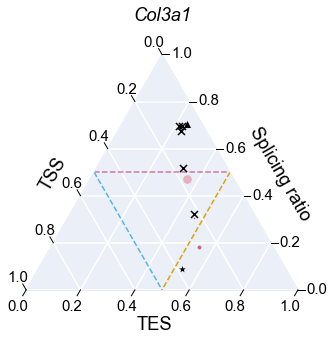

In [152]:
plot_simplex_here(ca, 'Col3a1', 'hippocampus', 'figures/')

['gastroc_10d', 'gastroc_14d', 'gastroc_18-20mo', 'gastroc_25d', 'gastroc_2mo', 'gastroc_36d', 'gastroc_4d', nan]
['vM25' 'vM21' 'lapa' 'all' 'obs_det' 'sample_det' 'obs_major'
 'sample_major' 'tissue_det' 'tissue_major' 'tissue_adult_det'
 'tissue_adult_major' 'tissue_tc_det_centroid']
figures//simplex_mef2a_tc_tissue_centroid_vs_sample.pdf


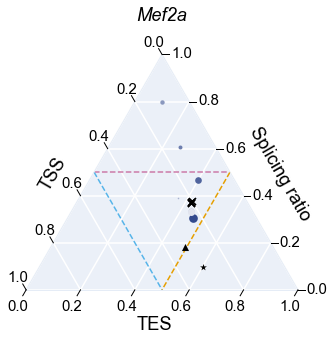

In [120]:
plot_simplex_here(ca, 'Mef2a', 'gastroc', 'figures/')